In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt 
from skimage.io import imread
from skimage.transform import warp, AffineTransform
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [10]:
!nvidia-smi

Tue Oct  8 15:48:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              2W /   20W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Aug_14_10:26:51_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.68
Build cuda_12.6.r12.6/compiler.34714021_0


In [12]:
print(torch.version.cuda)

11.8


In [13]:
# verify gpu 
print(torch.cuda.is_available())

True


In [14]:
dr = "../GAN/galaxies/"
batch_size = 128 
image_size = 64

In [15]:
data = dset.ImageFolder(root=dr,
                        transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(), 
                            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                        ]))

In [16]:
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)
device = torch.device("cuda")

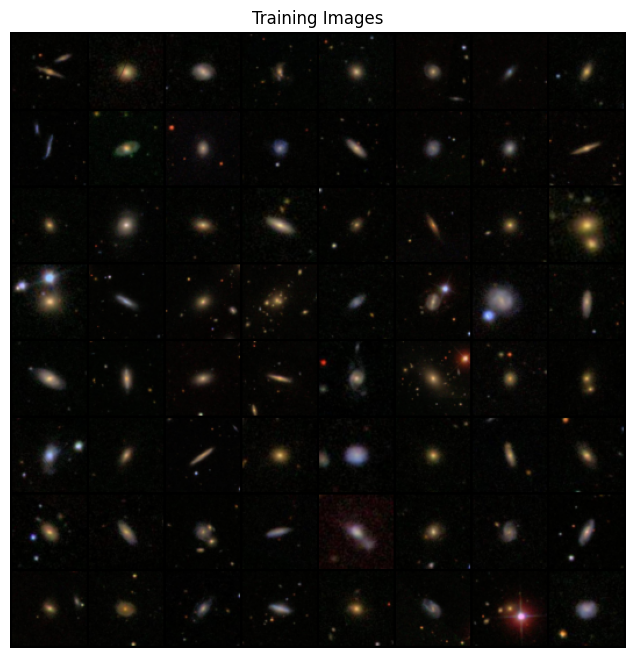

In [17]:
real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64]).cpu(),(1,2,0)))
plt.show()

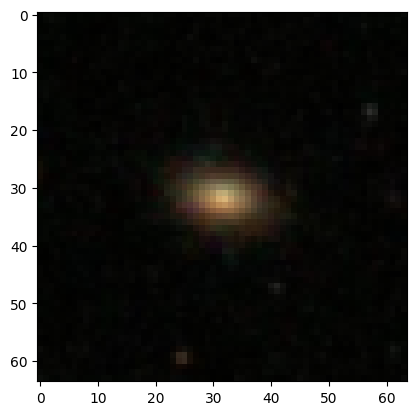

In [18]:
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[18]).cpu(),(1,2,0)))
plt.show()

In [27]:
# Rotate image in random orientation 
def distort(img):
    #rotRadians = np.random.uniform(0, 2*np.pi) 
    rotRadians = 1
    recenter_translate = (-img.shape[1] // 2, -img.shape[0] // 2) 
    recenter_translate_2 = (img.shape[1] // 2, img.shape[0] // 2) 
    shift = np.concatenate([np.arange(-10, -5), np.arange(5, 10)])
    translation = np.random.choice(shift, size=2)
    transformedImage = warp(img, AffineTransform(translation = recenter_translate) +
                            AffineTransform(rotation = rotRadians) +
                            AffineTransform(translation = recenter_translate_2 + translation))
    return torch.tensor(transformedImage)

In [28]:
def blend(img1, img2):
    blended = [np.max(np.dstack([img1[:, :, i], img2[:, :, i]]), -1) for i in range(img1.shape[-1])]
    return np.dstack(blended)

In [29]:
def batch_process():
    b1 = next(iter(loader))[0]
    b2_undistorted = next(iter(loader))[0]
    b2_undistorted = np.transpose(b2_undistorted, (0, 2, 3, 1))
    b1 = np.transpose(b1, (0, 2, 3, 1))    
    b2 = np.array([distort(img.cpu().numpy()) for img in b2_undistorted])
    b2 = torch.tensor(b2)

    print(type(b1[0]))
    print(type(b1[0]))
    
    blended = [] 
    for i in range(batch_size):
        blended.append(blend(b1[i], b2[i])) 
    blended = torch.tensor(blended)
        
    b1 = np.transpose(b1, (0, 3, 1, 2))
    b2 = np.transpose(b2, (0, 3, 1, 2))
    b2_undistorted = np.transpose(b2_undistorted, (0, 3, 1, 2))
    print(blended.shape)
    blended = np.transpose(blended, (0, 3, 1, 2))
    print(f"b1 shape: {b1.shape}")
    print(f"b2_undistorted shape: {b2.shape}")
    return b1, b2_undistorted, b2, blended

In [30]:
# This is code to test the blender 
b1, b2_undist, b2, blended = batch_process()

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([128, 64, 64, 3])
b1 shape: torch.Size([128, 3, 64, 64])
b2_undistorted shape: torch.Size([128, 3, 64, 64])


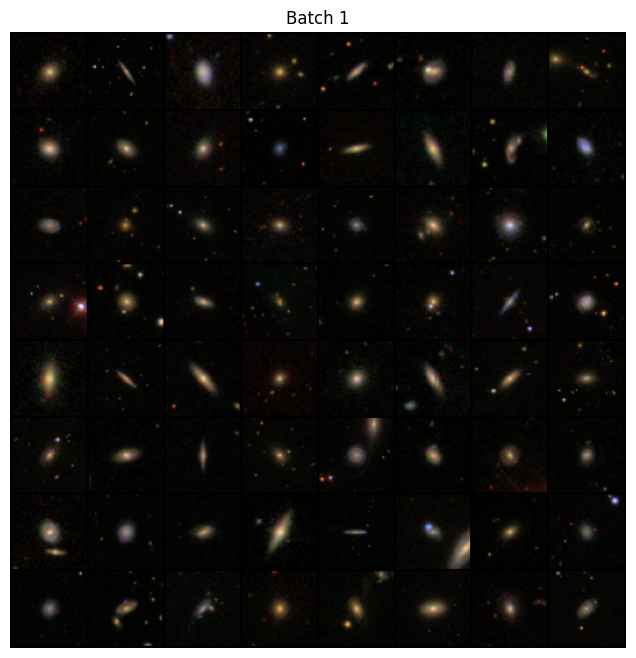

In [31]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch 1")
plt.imshow(np.transpose(vutils.make_grid(b1.to(device)[:64]).cpu(),(1,2,0)))
plt.show()

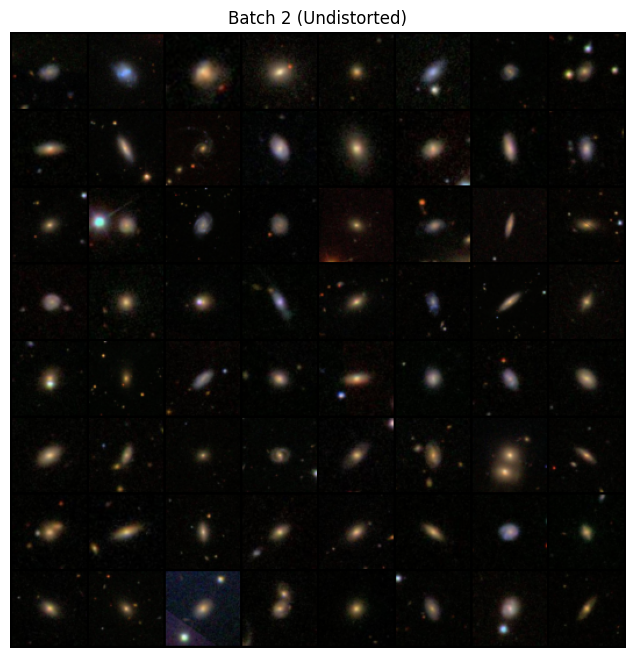

In [32]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch 2 (Undistorted)")
plt.imshow(np.transpose(vutils.make_grid(b2_undist.to(device)[:64]).cpu(),(1,2,0)))
plt.show()

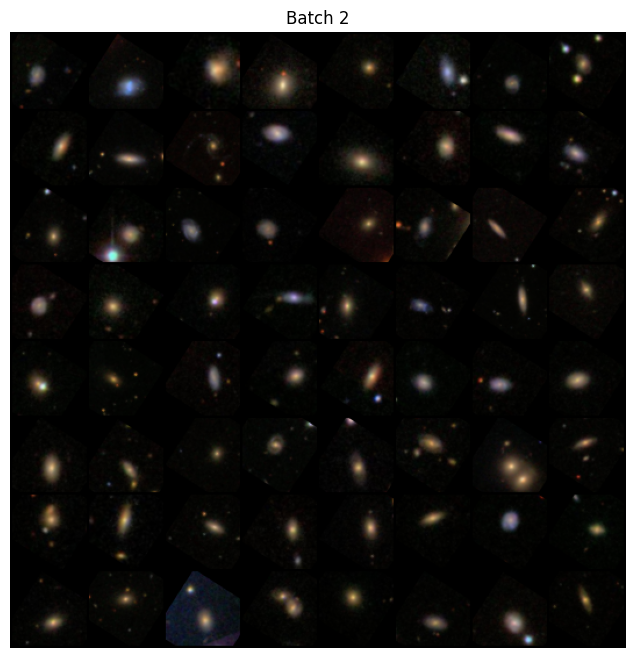

In [33]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch 2")
plt.imshow(np.transpose(vutils.make_grid(b2.to(device)[:64]).cpu(),(1,2,0)))
plt.show()

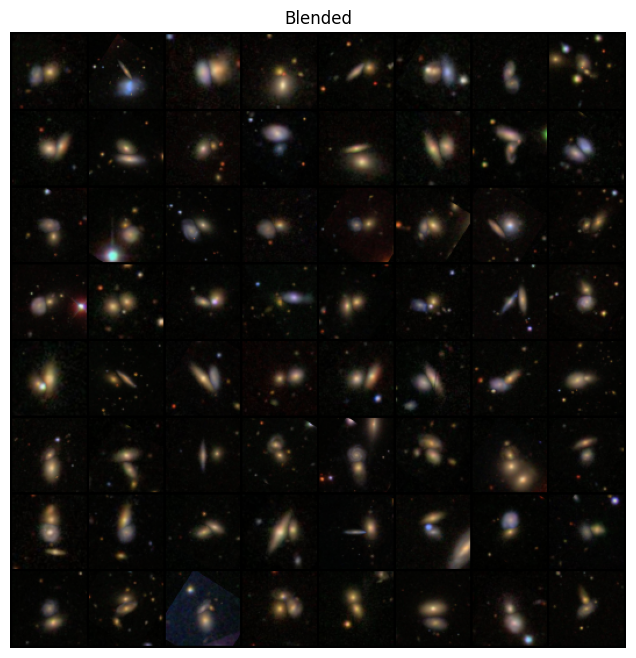

In [34]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Blended")
plt.imshow(np.transpose(vutils.make_grid(blended.to(device)[:64]).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Encoder Architecture (based on Autoencoding beyond pixels using a learned similarity metric)
# 5×5 64 conv. ↓, BNorm, ReLU
# 5×5 128 conv. ↓, BNorm, ReLU
# 5×5 256 conv. ↓, BNorm, ReLU
# 2048 fully-connected, BNorm, ReLU

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.p1 = nn.Sequential(

            # Layer 1 
            nn.Conv2d(3, 64, 5, 2, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Layer 2 
            nn.Conv2d(64, 128, 5, 2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Layer 3
            nn.Conv2d(128, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
         
        self.p2 = nn.Sequential(
            # Layer 4 - 
            nn.Linear(256 * 8 * 8, 2048),
            nn.BatchNorm1d(2048), 
            nn.ReLU(),
        )

    def forward(self, input):
        out = self.p1(input)
        out = out.view(len(out), -1)
        out = self.p2(out)
        return out
            
        

In [ ]:
# Decoder Architecture (based on Autoencoding beyond pixels using a learned similarity metric)
# 8·8·256 fully-connected, BNorm, ReLU
# 5×5 256 conv. ↑, BNorm, ReLU
# 5×5 128 conv. ↑, BNorm, ReLU
# 5×5 32 conv. ↑, BNorm, ReLU
# 5×5 3 conv., tanh

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.start = nn.Sequential(
            # Layer 1 
            nn.Linear(2048, 8*8*256),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU())

        self.main = nn.Sequential(
            # Layer 2
            nn.ConvTranspose2d(256, 128, 5, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 

            # Layer 3 
            nn.ConvTranspose2d(128, 32, 5, 2, 1),
            nn.BatchNorm2d(),
            nn.ReLU(),

            # Layer 4
            nn.ConvTranspose2d(32, 3, 5, 2, 1),
            nn.Tanh()
        )

    def forward(self, input):
        out = self.start(input)
        out = out.view(len(out), 256, 8, 8)
        out = self.main(out)
        return out 
            


In [ ]:
# Discriminator Architecture (based on Autoencoding beyond pixels using a learned similarity metric)
# 5×5 32 conv., ReLU
# 5×5 128 conv. ↓, BNorm, ReLU
# 5×5 256 conv. ↓, BNorm, ReLU
# 5×5 256 conv. ↓, BNorm, ReLU
# 512 fully-connected, BNorm, ReLU
# 1 fully-connected, sigmoid

#### I AM NOT SURE OF THE PADDING/STRIDE FOR THESE

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.p1 = nn.Sequential(
            # Layer 1 
            nn.Conv2d(3, 32, 5, 1, 2), 
            nn.ReLU(), 

            # Layer 2
            nn.Conv2d(32, 128, 5, 2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(), 

            # Layer 3 
            nn.Conv2d(128, 256, 2, 2),
            nn.BatchNorm2d(256), 
            nn.ReLU(), 

            # Layer 4 
            nn.Conv2d(256, 256, 2, 2), 
            nn.BatchNorm2d(256), 
            nn.ReLU(),
        )

        self.p2 = nn.Sequential(
            # Layer 5
            nn.Linear(256 * 8 * 8, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),

            # Layer 6 
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        out = self.p1(input)
        out = out.view(len(out), -1)
        out = self.p2(out)
        return out

In [ ]:
# VAE Loss Function 


In [ ]:
# train the neural net (for now just generating some galaxy images :))


In [ ]:
# evaluate results